In [ ]:
# install rdkit  
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!conda install -q -y -c rdkit rdkit python=3.7
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import pprint     
pprint.pprint(sys.path)
!python -c "import site; print (site.getsitepackages())"

In [2]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q SmilesPE

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
import transformers
transformers.__version__

'4.22.0.dev0'

In [4]:
from SmilesPE.tokenizer import *

In [5]:
# Tokenizaion classes for huggingface interface
# reference: https://github.com/huggingface/transformers/blob/master/src/transformers/tokenization_bert.py
# reference https://github.com/rxn4chemistry/rxnmapper

import collections
import logging
import os
import re
import codecs
import unicodedata
from typing import List, Optional
from transformers import PreTrainedTokenizer
from SmilesPE.tokenizer import SPE_Tokenizer

def load_vocab(vocab_file):
    """Loads a vocabulary file into a dictionary."""
    vocab = collections.OrderedDict()
    with open(vocab_file, "r", encoding="utf-8") as reader:
        tokens = reader.readlines()
    for index, token in enumerate(tokens):
        token = token.rstrip("\n")
        vocab[token] = index
    return vocab

class Atomwise_Tokenizer(object):
    """Run atom-level SMILES tokenization"""

    def __init__(self):
        """ Constructs a atom-level Tokenizer.
        """
        self.regex_pattern = r"(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\|\/|:|~|@|\?|>>?|\*|\$|\%[0-9]{2}|[0-9])"
        self.regex = re.compile(self.regex_pattern)

    def tokenize(self, text):
        """ Basic Tokenization of a SMILES.
        """
        tokens = [token for token in self.regex.findall(text)]
        return tokens
    
class SMILES_SPE_Tokenizer(PreTrainedTokenizer):
    r"""
    Constructs a SMILES tokenizer. Based on SMILES Pair Encoding (https://github.com/XinhaoLi74/SmilesPE).
    This tokenizer inherits from :class:`~transformers.PreTrainedTokenizer` which contains most of the methods. Users
    should refer to the superclass for more information regarding methods.
    Args:
        vocab_file (:obj:`string`):
            File containing the vocabulary.
        spe_file (:obj:`string`):
            File containing the trained SMILES Pair Encoding vocabulary.
        unk_token (:obj:`string`, `optional`, defaults to "[UNK]"):
            The unknown token. A token that is not in the vocabulary cannot be converted to an ID and is set to be this
            token instead.
        sep_token (:obj:`string`, `optional`, defaults to "[SEP]"):
            The separator token, which is used when building a sequence from multiple sequences, e.g. two sequences
            for sequence classification or for a text and a question for question answering.
            It is also used as the last token of a sequence built with special tokens.
        pad_token (:obj:`string`, `optional`, defaults to "[PAD]"):
            The token used for padding, for example when batching sequences of different lengths.
        cls_token (:obj:`string`, `optional`, defaults to "[CLS]"):
            The classifier token which is used when doing sequence classification (classification of the whole
            sequence instead of per-token classification). It is the first token of the sequence when built with
            special tokens.
        mask_token (:obj:`string`, `optional`, defaults to "[MASK]"):
            The token used for masking values. This is the token used when training this model with masked language
            modeling. This is the token which the model will try to predict.
    """

    def __init__(
        self,
        vocab_file,
        spe_file,
        unk_token="[UNK]",
        sep_token="[SEP]",
        pad_token="[PAD]",
        cls_token="[CLS]",
        mask_token="[MASK]",
        **kwargs
    ):
        super().__init__(
            unk_token=unk_token,
            sep_token=sep_token,
            pad_token=pad_token,
            cls_token=cls_token,
            mask_token=mask_token,
            **kwargs,
        )

        if not os.path.isfile(vocab_file):
            raise ValueError(
                "Can't find a vocabulary file at path '{}'.".format(vocab_file)
            )
        if not os.path.isfile(spe_file):
            raise ValueError(
                "Can't find a SPE vocabulary file at path '{}'.".format(spe_file)
            )
        self.vocab = load_vocab(vocab_file)
        self.spe_vocab = codecs.open(spe_file)
        self.ids_to_tokens = collections.OrderedDict([(ids, tok) for tok, ids in self.vocab.items()])
        self.spe_tokenizer = SPE_Tokenizer(self.spe_vocab)

    @property
    def vocab_size(self):
        return len(self.vocab)

    def get_vocab(self):
        return dict(self.vocab, **self.added_tokens_encoder)

    def _tokenize(self, text):
        return self.spe_tokenizer.tokenize(text).split(' ')

    def _convert_token_to_id(self, token):
        """ Converts a token (str) in an id using the vocab. """
        return self.vocab.get(token, self.vocab.get(self.unk_token))

    def _convert_id_to_token(self, index):
        """Converts an index (integer) in a token (str) using the vocab."""
        return self.ids_to_tokens.get(index, self.unk_token)

    def convert_tokens_to_string(self, tokens):
        """ Converts a sequence of tokens (string) in a single string. """
        out_string = " ".join(tokens).replace(" ##", "").strip()
        return out_string

    def build_inputs_with_special_tokens(
        self, token_ids_0: List[int], token_ids_1: Optional[List[int]] = None
    ) -> List[int]:
        """
        Build model inputs from a sequence or a pair of sequence for sequence classification tasks
        by concatenating and adding special tokens.
        A BERT sequence has the following format:
        - single sequence: ``[CLS] X [SEP]``
        - pair of sequences: ``[CLS] A [SEP] B [SEP]``
        Args:
            token_ids_0 (:obj:`List[int]`):
                List of IDs to which the special tokens will be added
            token_ids_1 (:obj:`List[int]`, `optional`, defaults to :obj:`None`):
                Optional second list of IDs for sequence pairs.
        Returns:
            :obj:`List[int]`: list of `input IDs <../glossary.html#input-ids>`__ with the appropriate special tokens.
        """
        if token_ids_1 is None:
            return [self.cls_token_id] + token_ids_0 + [self.sep_token_id]
        cls = [self.cls_token_id]
        sep = [self.sep_token_id]
        return cls + token_ids_0 + sep + token_ids_1 + sep

    def get_special_tokens_mask(
        self, token_ids_0: List[int], token_ids_1: Optional[List[int]] = None, already_has_special_tokens: bool = False
    ) -> List[int]:
        """
        Retrieves sequence ids from a token list that has no special tokens added. This method is called when adding
        special tokens using the tokenizer ``prepare_for_model`` method.
        Args:
            token_ids_0 (:obj:`List[int]`):
                List of ids.
            token_ids_1 (:obj:`List[int]`, `optional`, defaults to :obj:`None`):
                Optional second list of IDs for sequence pairs.
            already_has_special_tokens (:obj:`bool`, `optional`, defaults to :obj:`False`):
                Set to True if the token list is already formatted with special tokens for the model
        Returns:
            :obj:`List[int]`: A list of integers in the range [0, 1]: 1 for a special token, 0 for a sequence token.
        """

        if already_has_special_tokens:
            if token_ids_1 is not None:
                raise ValueError(
                    "You should not supply a second sequence if the provided sequence of "
                    "ids is already formated with special tokens for the model."
                )
            return list(map(lambda x: 1 if x in [self.sep_token_id, self.cls_token_id] else 0, token_ids_0))

        if token_ids_1 is not None:
            return [1] + ([0] * len(token_ids_0)) + [1] + ([0] * len(token_ids_1)) + [1]
        return [1] + ([0] * len(token_ids_0)) + [1]

    def create_token_type_ids_from_sequences(
        self, token_ids_0: List[int], token_ids_1: Optional[List[int]] = None
    ) -> List[int]:
        """
        Creates a mask from the two sequences passed to be used in a sequence-pair classification task.
        A BERT sequence pair mask has the following format:
        ::
            0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
            | first sequence    | second sequence |
        if token_ids_1 is None, only returns the first portion of the mask (0's).
        Args:
            token_ids_0 (:obj:`List[int]`):
                List of ids.
            token_ids_1 (:obj:`List[int]`, `optional`, defaults to :obj:`None`):
                Optional second list of IDs for sequence pairs.
        Returns:
            :obj:`List[int]`: List of `token type IDs <../glossary.html#token-type-ids>`_ according to the given
            sequence(s).
        """
        sep = [self.sep_token_id]
        cls = [self.cls_token_id]
        if token_ids_1 is None:
            return len(cls + token_ids_0 + sep) * [0]
        return len(cls + token_ids_0 + sep) * [0] + len(token_ids_1 + sep) * [1]

    def save_vocabulary(self, vocab_path):
        """
        Save the sentencepiece vocabulary (copy original file) and special tokens file to a directory.
        Args:
            vocab_path (:obj:`str`):
                The directory in which to save the vocabulary.
        Returns:
            :obj:`Tuple(str)`: Paths to the files saved.
        """
        index = 0
        if os.path.isdir(vocab_path):
            vocab_file = os.path.join(vocab_path, VOCAB_FILES_NAMES["vocab_file"])
        else:
            vocab_file = vocab_path
        with open(vocab_file, "w", encoding="utf-8") as writer:
            for token, token_index in sorted(self.vocab.items(), key=lambda kv: kv[1]):
                if index != token_index:
                    logger.warning(
                        "Saving vocabulary to {}: vocabulary indices are not consecutive."
                        " Please check that the vocabulary is not corrupted!".format(vocab_file)
                    )
                    index = token_index
                writer.write(token + "\n")
                index += 1
        return (vocab_file,)

class Atomwise_Tokenizer(object):
    """Run atom-level SMILES tokenization"""

    def __init__(self):
        """ Constructs a atom-level Tokenizer.
        """
        self.regex_pattern = r"(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\|\/|:|~|@|\?|>>?|\*|\$|\%[0-9]{2}|[0-9])"
        self.regex = re.compile(self.regex_pattern)

    def tokenize(self, text):
        """ Basic Tokenization of a SMILES.
        """
        tokens = [token for token in self.regex.findall(text)]
        return tokens

class SMILES_Atomwise_Tokenizer(PreTrainedTokenizer):
    r"""
    Constructs a SMILES tokenizer. Based on SMILES Pair Encoding (https://github.com/XinhaoLi74/SmilesPE).
    This tokenizer inherits from :class:`~transformers.PreTrainedTokenizer` which contains most of the methods. Users
    should refer to the superclass for more information regarding methods.
    Args:
        vocab_file (:obj:`string`):
            File containing the vocabulary.
        unk_token (:obj:`string`, `optional`, defaults to "[UNK]"):
            The unknown token. A token that is not in the vocabulary cannot be converted to an ID and is set to be this
            token instead.
        sep_token (:obj:`string`, `optional`, defaults to "[SEP]"):
            The separator token, which is used when building a sequence from multiple sequences, e.g. two sequences
            for sequence classification or for a text and a question for question answering.
            It is also used as the last token of a sequence built with special tokens.
        pad_token (:obj:`string`, `optional`, defaults to "[PAD]"):
            The token used for padding, for example when batching sequences of different lengths.
        cls_token (:obj:`string`, `optional`, defaults to "[CLS]"):
            The classifier token which is used when doing sequence classification (classification of the whole
            sequence instead of per-token classification). It is the first token of the sequence when built with
            special tokens.
        mask_token (:obj:`string`, `optional`, defaults to "[MASK]"):
            The token used for masking values. This is the token used when training this model with masked language
            modeling. This is the token which the model will try to predict.
    """

    def __init__(
        self,
        vocab_file,
        unk_token="[UNK]",
        sep_token="[SEP]",
        pad_token="[PAD]",
        cls_token="[CLS]",
        mask_token="[MASK]",
        **kwargs
    ):
        super().__init__(
            unk_token=unk_token,
            sep_token=sep_token,
            pad_token=pad_token,
            cls_token=cls_token,
            mask_token=mask_token,
            **kwargs,
        )

        if not os.path.isfile(vocab_file):
            raise ValueError(
                "Can't find a vocabulary file at path '{}'.".format(vocab_file)
            )
        self.vocab = load_vocab(vocab_file)
        self.ids_to_tokens = collections.OrderedDict([(ids, tok) for tok, ids in self.vocab.items()])
        self.tokenizer = Atomwise_Tokenizer()

    @property
    def vocab_size(self):
        return len(self.vocab)

    def get_vocab(self):
        return dict(self.vocab, **self.added_tokens_encoder)

    def _tokenize(self, text):
        return self.tokenizer.tokenize(text)

    def _convert_token_to_id(self, token):
        """ Converts a token (str) in an id using the vocab. """
        return self.vocab.get(token, self.vocab.get(self.unk_token))

    def _convert_id_to_token(self, index):
        """Converts an index (integer) in a token (str) using the vocab."""
        return self.ids_to_tokens.get(index, self.unk_token)

    def convert_tokens_to_string(self, tokens):
        """ Converts a sequence of tokens (string) in a single string. """
        out_string = " ".join(tokens).replace(" ##", "").strip()
        return out_string

    def build_inputs_with_special_tokens(
        self, token_ids_0: List[int], token_ids_1: Optional[List[int]] = None
    ) -> List[int]:
        """
        Build model inputs from a sequence or a pair of sequence for sequence classification tasks
        by concatenating and adding special tokens.
        A BERT sequence has the following format:
        - single sequence: ``[CLS] X [SEP]``
        - pair of sequences: ``[CLS] A [SEP] B [SEP]``
        Args:
            token_ids_0 (:obj:`List[int]`):
                List of IDs to which the special tokens will be added
            token_ids_1 (:obj:`List[int]`, `optional`, defaults to :obj:`None`):
                Optional second list of IDs for sequence pairs.
        Returns:
            :obj:`List[int]`: list of `input IDs <../glossary.html#input-ids>`__ with the appropriate special tokens.
        """
        if token_ids_1 is None:
            return [self.cls_token_id] + token_ids_0 + [self.sep_token_id]
        cls = [self.cls_token_id]
        sep = [self.sep_token_id]
        return cls + token_ids_0 + sep + token_ids_1 + sep

    def get_special_tokens_mask(
        self, token_ids_0: List[int], token_ids_1: Optional[List[int]] = None, already_has_special_tokens: bool = False
    ) -> List[int]:
        """
        Retrieves sequence ids from a token list that has no special tokens added. This method is called when adding
        special tokens using the tokenizer ``prepare_for_model`` method.
        Args:
            token_ids_0 (:obj:`List[int]`):
                List of ids.
            token_ids_1 (:obj:`List[int]`, `optional`, defaults to :obj:`None`):
                Optional second list of IDs for sequence pairs.
            already_has_special_tokens (:obj:`bool`, `optional`, defaults to :obj:`False`):
                Set to True if the token list is already formatted with special tokens for the model
        Returns:
            :obj:`List[int]`: A list of integers in the range [0, 1]: 1 for a special token, 0 for a sequence token.
        """

        if already_has_special_tokens:
            if token_ids_1 is not None:
                raise ValueError(
                    "You should not supply a second sequence if the provided sequence of "
                    "ids is already formated with special tokens for the model."
                )
            return list(map(lambda x: 1 if x in [self.sep_token_id, self.cls_token_id] else 0, token_ids_0))

        if token_ids_1 is not None:
            return [1] + ([0] * len(token_ids_0)) + [1] + ([0] * len(token_ids_1)) + [1]
        return [1] + ([0] * len(token_ids_0)) + [1]

    def create_token_type_ids_from_sequences(
        self, token_ids_0: List[int], token_ids_1: Optional[List[int]] = None
    ) -> List[int]:
        """
        Creates a mask from the two sequences passed to be used in a sequence-pair classification task.
        A BERT sequence pair mask has the following format:
        ::
            0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
            | first sequence    | second sequence |
        if token_ids_1 is None, only returns the first portion of the mask (0's).
        Args:
            token_ids_0 (:obj:`List[int]`):
                List of ids.
            token_ids_1 (:obj:`List[int]`, `optional`, defaults to :obj:`None`):
                Optional second list of IDs for sequence pairs.
        Returns:
            :obj:`List[int]`: List of `token type IDs <../glossary.html#token-type-ids>`_ according to the given
            sequence(s).
        """
        sep = [self.sep_token_id]
        cls = [self.cls_token_id]
        if token_ids_1 is None:
            return len(cls + token_ids_0 + sep) * [0]
        return len(cls + token_ids_0 + sep) * [0] + len(token_ids_1 + sep) * [1]

    def save_vocabulary(self, vocab_path):
        """
        Save the sentencepiece vocabulary (copy original file) and special tokens file to a directory.
        Args:
            vocab_path (:obj:`str`):
                The directory in which to save the vocabulary.
        Returns:
            :obj:`Tuple(str)`: Paths to the files saved.
        """
        index = 0
        if os.path.isdir(vocab_path):
            vocab_file = os.path.join(vocab_path, VOCAB_FILES_NAMES["vocab_file"])
        else:
            vocab_file = vocab_path
        with open(vocab_file, "w", encoding="utf-8") as writer:
            for token, token_index in sorted(self.vocab.items(), key=lambda kv: kv[1]):
                if index != token_index:
                    logger.warning(
                        "Saving vocabulary to {}: vocabulary indices are not consecutive."
                        " Please check that the vocabulary is not corrupted!".format(vocab_file)
                    )
                    index = token_index
                writer.write(token + "\n")
                index += 1
        return (vocab_file,)



In [6]:
!wget https://raw.githubusercontent.com/XinhaoLi74/SmilesPE/master/SPE_ChEMBL.txt

--2022-08-23 11:09:14--  https://raw.githubusercontent.com/XinhaoLi74/SmilesPE/master/SPE_ChEMBL.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27879 (27K) [text/plain]
Saving to: ‘SPE_ChEMBL.txt.5’

SPE_ChEMBL.txt.5    100%[===================>]  27.23K  --.-KB/s    in 0s      

2022-08-23 11:09:14 (95.3 MB/s) - ‘SPE_ChEMBL.txt.5’ saved [27879/27879]



In [7]:
# some default tokens from huggingface
default_toks = ['[PAD]', 
                '[unused1]', '[unused2]', '[unused3]', '[unused4]','[unused5]', '[unused6]', '[unused7]', '[unused8]', '[unused9]', '[unused10]', 
                '[UNK]', '[CLS]', '[SEP]', '[MASK]']

# atom-level tokens used for trained the spe vocabulary
atom_toks = ['[c-]', '[SeH]', '[N]', '[C@@]', '[Te]', '[OH+]', 'n', '[AsH]', '[B]', 'b', 
             '[S@@]', 'o', ')', '[NH+]', '[SH]', 'O', 'I', '[C@]', '-', '[As+]', '[Cl+2]', 
             '[P+]', '[o+]', '[C]', '[C@H]', '[CH2]', '\\', 'P', '[O-]', '[NH-]', '[S@@+]', 
             '[te]', '[s+]', 's', '[B-]', 'B', 'F', '=', '[te+]', '[H]', '[C@@H]', '[Na]', 
             '[Si]', '[CH2-]', '[S@+]', 'C', '[se+]', '[cH-]', '6', 'N', '[IH2]', '[As]', 
             '[Si@]', '[BH3-]', '[Se]', 'Br', '[C+]', '[I+3]', '[b-]', '[P@+]', '[SH2]', '[I+2]', 
             '%11', '[Ag-3]', '[O]', '9', 'c', '[N-]', '[BH-]', '4', '[N@+]', '[SiH]', '[Cl+3]', '#', 
             '(', '[O+]', '[S-]', '[Br+2]', '[nH]', '[N+]', '[n-]', '3', '[Se+]', '[P@@]', '[Zn]', '2', 
             '[NH2+]', '%10', '[SiH2]', '[nH+]', '[Si@@]', '[P@@+]', '/', '1', '[c+]', '[S@]', '[S+]', 
             '[SH+]', '[B@@-]', '8', '[B@-]', '[C-]', '7', '[P@]', '[se]', 'S', '[n+]', '[PH]', '[I+]', '5', 'p', '[BH2-]', '[N@@+]', '[CH]', 'Cl']

# spe tokens
with open('SPE_ChEMBL.txt', "r") as ins:
    spe_toks = []
    for line in ins:
        spe_toks.append(line.split('\n')[0])

spe_tokens = []
for s in spe_toks:
    spe_tokens.append(''.join(s.split(' ')))
print('Number of SMILES:', len(spe_toks))

Number of SMILES: 3002


In [8]:
spe_vocab = default_toks + atom_toks + spe_tokens
len(spe_vocab)

3132

In [9]:
with open('vocab_spe.txt', 'w') as f:
    for voc in spe_vocab:
        f.write(f'{voc}\n')

In [10]:
tokenizer = SMILES_SPE_Tokenizer(vocab_file='vocab_spe.txt', spe_file= 'SPE_ChEMBL.txt')

In [11]:
import pandas as pd
df = pd.read_csv('top_20_MOAs.txt', sep = '\t')
df

,SMILES,MOA
0,CCCC(=O)Nc1ccc(OCC(O)CNC(C)C)c(c1)C(C)=O,adrenergic receptor antagonist
1,COc1cc2nc(nc(N)c2cc1OC)N(C)CCCNC(=O)C1CCCO1,adrenergic receptor antagonist
2,CC(C)NCC(O)COc1ccccc1CC=C,adrenergic receptor antagonist
3,COc1ccccc1N1CCN(CCN2C(=O)c3ccccc3C(C)(C)C2=O)CC1,adrenergic receptor antagonist
4,CC(C)(C)NCC(O)CSc1nc(cs1)-c1ccc(s1)C(N)=O,adrenergic receptor antagonist
...,...,...
1216,OCCCC(O)=O,benzodiazepine receptor agonist
1217,CN1c2ccc(Cl)cc2C(=NC(O)C1=O)c1ccccc1,benzodiazepine receptor agonist
1218,CCN(C(C)=O)c1cccc(c1)-c1ccnc2c(cnn12)C#N,benzodiazepine receptor agonist
1219,CCOC(=O)c1ncc2[nH]c3ccc(OCc4ccccc4)cc3c2c1COC,benzodiazepine receptor agonist


In [12]:
# check the duplicates 
for i in df.SMILES.tolist():
  if df.SMILES.tolist().count(i) != 1:
    print(i)

In [13]:
MOA_class_dictionary = {'EGFR inhibitor': 8,
 'HDAC inhibitor': 16,
 'PI3K inhibitor': 13,
 'acetylcholine receptor agonist': 1,
 'acetylcholine receptor antagonist': 4,
 'adrenergic receptor agonist': 18,
 'adrenergic receptor antagonist': 15,
 'bacterial cell wall synthesis inhibitor': 14,
 'benzodiazepine receptor agonist': 10,
 'calcium channel blocker': 5,
 'cyclooxygenase inhibitor': 6,
 'dopamine receptor antagonist': 12,
 'glucocorticoid receptor agonist': 9,
 'glutamate receptor antagonist': 19,
 'histamine receptor antagonist': 17,
 'phosphodiesterase inhibitor': 3,
 'serotonin receptor agonist': 7,
 'serotonin receptor antagonist': 2,
 'sodium channel blocker': 11,
 'topoisomerase inhibitor': 0}

In [14]:
sorted_classes = list(MOA_class_dictionary.values())
sorted_classes.sort() 
assert sorted_classes == [i for i in range(20)]

In [15]:
# add classes column 
df['classes'] = None
for i in range(df.shape[0]):
  df.iloc[i,2] = MOA_class_dictionary[df.iloc[i,1]]
df

,SMILES,MOA,classes
0,CCCC(=O)Nc1ccc(OCC(O)CNC(C)C)c(c1)C(C)=O,adrenergic receptor antagonist,15
1,COc1cc2nc(nc(N)c2cc1OC)N(C)CCCNC(=O)C1CCCO1,adrenergic receptor antagonist,15
2,CC(C)NCC(O)COc1ccccc1CC=C,adrenergic receptor antagonist,15
3,COc1ccccc1N1CCN(CCN2C(=O)c3ccccc3C(C)(C)C2=O)CC1,adrenergic receptor antagonist,15
4,CC(C)(C)NCC(O)CSc1nc(cs1)-c1ccc(s1)C(N)=O,adrenergic receptor antagonist,15
...,...,...,...
1216,OCCCC(O)=O,benzodiazepine receptor agonist,10
1217,CN1c2ccc(Cl)cc2C(=NC(O)C1=O)c1ccccc1,benzodiazepine receptor agonist,10
1218,CCN(C(C)=O)c1cccc(c1)-c1ccnc2c(cnn12)C#N,benzodiazepine receptor agonist,10
1219,CCOC(=O)c1ncc2[nH]c3ccc(OCc4ccccc4)cc3c2c1COC,benzodiazepine receptor agonist,10


In [16]:
# A function that changes smiles string to fingerprints 
import rdkit
import numpy as np
from rdkit import *
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
def smiles_to_array_to_string(smiles):
  molecules = Chem.MolFromSmiles(smiles) 
  fingerprints = AllChem.GetMorganFingerprintAsBitVect(molecules, 2)
  x_array = []
  arrays  = np.zeros(0,)
  DataStructs.ConvertToNumpyArray(fingerprints, arrays)
  x_array.append(arrays)
  x_array = np.asarray(x_array)
  x_array = list((np.squeeze(x_array)).astype(int))
  string = ''
  for i in x_array:
    string += str(i) 
  return string

In [17]:
# Check the existence of Isomers
assert len(set([smiles_to_array_to_string(i) for i in df.SMILES.tolist()])) == df.shape[0]

In [18]:
df.head(3)[['MOA', 'classes', 'SMILES']]

,MOA,classes,SMILES
0,adrenergic receptor antagonist,15,CCCC(=O)Nc1ccc(OCC(O)CNC(C)C)c(c1)C(C)=O
1,adrenergic receptor antagonist,15,COc1cc2nc(nc(N)c2cc1OC)N(C)CCCNC(=O)C1CCCO1
2,adrenergic receptor antagonist,15,CC(C)NCC(O)COc1ccccc1CC=C


In [19]:
# Split out the test set  
from sklearn.model_selection import train_test_split
x_train_valid, x_test, y_train_valid, y_test = train_test_split(df.SMILES, df.classes, test_size =10/100,
 stratify = df.classes, shuffle = True, random_state = 1000)

In [20]:
# kfold
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits = 9)
skf.get_n_splits(np.array(list(x_train_valid)), np.array(list(y_train_valid)))
train_index_list = []
valid_index_list = []
for train_index, valid_index in skf.split(np.array(list(x_train_valid)), np.array(list(y_train_valid))):
  train_index_list.append(train_index)
  valid_index_list.append(valid_index)

In [21]:
number_of_kfold = 0 # change the number from 0-8 to get 9 shuffles

In [22]:
  x_train = list(np.array(list(x_train_valid))[train_index_list[ number_of_kfold ]])
  x_valid = list(np.array(list(x_train_valid))[valid_index_list[ number_of_kfold ]])
  y_train = list(np.array(list(y_train_valid))[train_index_list[ number_of_kfold ]])
  y_valid = list(np.array(list(y_train_valid))[valid_index_list[ number_of_kfold ]])
  x_test = list(x_test)
  y_test = list(y_test)

In [23]:
from rdkit import Chem  # turn to cannoical  smiles
x_train = [Chem.MolToSmiles(Chem.MolFromSmiles(smi),True) for smi in x_train]
x_valid = [Chem.MolToSmiles(Chem.MolFromSmiles(smi),True) for smi in x_valid]
x_test = [Chem.MolToSmiles(Chem.MolFromSmiles(smi),True) for smi in x_test]

In [24]:
train_dataset = pd.concat([pd.DataFrame(x_train), pd.DataFrame(y_train),], axis = 1)
valid_dataset = pd.concat([pd.DataFrame(x_valid), pd.DataFrame(y_valid),], axis = 1)
test_dataset = pd.concat([pd.DataFrame(x_test), pd.DataFrame(y_test),], axis = 1)

In [25]:
def randomize_smiles(smiles):
    m = Chem.MolFromSmiles(smiles)
    ans = list(range(m.GetNumAtoms()))
    np.random.shuffle(ans)
    nm = Chem.RenumberAtoms(m,ans)
    return Chem.MolToSmiles(nm, canonical=False, isomericSmiles=True, kekuleSmiles=False)

In [26]:
def smiles_augmentation(df, N_rounds):
    dist_aug = {col_name: [] for col_name in df}

    for i in range(df.shape[0]):
        if df.iloc[i].p_np == 0:
            for j in range(N_rounds[0]):
                dist_aug['smiles'].append(randomize_smiles(df.iloc[i].smiles))
                dist_aug['p_np'].append(df.iloc[i]['p_np'])

        if df.iloc[i].p_np == 1:
            for j in range(N_rounds[1]):
                dist_aug['smiles'].append(randomize_smiles(df.iloc[i].smiles))
                dist_aug['p_np'].append(df.iloc[i]['p_np'])
        if df.iloc[i].p_np == 2:
            for j in range(N_rounds[2]):
                dist_aug['smiles'].append(randomize_smiles(df.iloc[i].smiles))
                dist_aug['p_np'].append(df.iloc[i]['p_np'])

        if df.iloc[i].p_np == 3:
            for j in range(N_rounds[3]):
                dist_aug['smiles'].append(randomize_smiles(df.iloc[i].smiles))
                dist_aug['p_np'].append(df.iloc[i]['p_np'])

        if df.iloc[i].p_np == 4:
            for j in range(N_rounds[4]):
                dist_aug['smiles'].append(randomize_smiles(df.iloc[i].smiles))
                dist_aug['p_np'].append(df.iloc[i]['p_np'])

        if df.iloc[i].p_np == 5:
            for j in range(N_rounds[5]):
                dist_aug['smiles'].append(randomize_smiles(df.iloc[i].smiles))
                dist_aug['p_np'].append(df.iloc[i]['p_np'])

        if df.iloc[i].p_np == 6:
            for j in range(N_rounds[6]):
                dist_aug['smiles'].append(randomize_smiles(df.iloc[i].smiles))
                dist_aug['p_np'].append(df.iloc[i]['p_np'])

        if df.iloc[i].p_np == 7:
            for j in range(N_rounds[7]):
                dist_aug['smiles'].append(randomize_smiles(df.iloc[i].smiles))
                dist_aug['p_np'].append(df.iloc[i]['p_np'])

        if df.iloc[i].p_np == 8:
            for j in range(N_rounds[8]):
                dist_aug['smiles'].append(randomize_smiles(df.iloc[i].smiles))
                dist_aug['p_np'].append(df.iloc[i]['p_np'])

        if df.iloc[i].p_np == 9:
            for j in range(N_rounds[9]):
                dist_aug['smiles'].append(randomize_smiles(df.iloc[i].smiles))
                dist_aug['p_np'].append(df.iloc[i]['p_np'])

        if df.iloc[i].p_np ==10:
            for j in range(N_rounds[10]):
                dist_aug['smiles'].append(randomize_smiles(df.iloc[i].smiles))
                dist_aug['p_np'].append(df.iloc[i]['p_np'])

        if df.iloc[i].p_np == 11:
            for j in range(N_rounds[11]):
                dist_aug['smiles'].append(randomize_smiles(df.iloc[i].smiles))
                dist_aug['p_np'].append(df.iloc[i]['p_np'])

        if df.iloc[i].p_np == 12:
            for j in range(N_rounds[12]):
                dist_aug['smiles'].append(randomize_smiles(df.iloc[i].smiles))
                dist_aug['p_np'].append(df.iloc[i]['p_np'])

        if df.iloc[i].p_np == 13:
            for j in range(N_rounds[13]):
                dist_aug['smiles'].append(randomize_smiles(df.iloc[i].smiles))
                dist_aug['p_np'].append(df.iloc[i]['p_np'])

        if df.iloc[i].p_np == 14:
            for j in range(N_rounds[14]):
                dist_aug['smiles'].append(randomize_smiles(df.iloc[i].smiles))
                dist_aug['p_np'].append(df.iloc[i]['p_np'])

        if df.iloc[i].p_np == 15:
            for j in range(N_rounds[15]):
                dist_aug['smiles'].append(randomize_smiles(df.iloc[i].smiles))
                dist_aug['p_np'].append(df.iloc[i]['p_np'])

        if df.iloc[i].p_np == 16:
            for j in range(N_rounds[16]):
                dist_aug['smiles'].append(randomize_smiles(df.iloc[i].smiles))
                dist_aug['p_np'].append(df.iloc[i]['p_np'])

        if df.iloc[i].p_np == 17:
            for j in range(N_rounds[17]):
                dist_aug['smiles'].append(randomize_smiles(df.iloc[i].smiles))
                dist_aug['p_np'].append(df.iloc[i]['p_np'])

        if df.iloc[i].p_np == 18:
            for j in range(N_rounds[18]):
                dist_aug['smiles'].append(randomize_smiles(df.iloc[i].smiles))
                dist_aug['p_np'].append(df.iloc[i]['p_np'])

        if df.iloc[i].p_np == 19:
            for j in range(N_rounds[19]):
                dist_aug['smiles'].append(randomize_smiles(df.iloc[i].smiles))
                dist_aug['p_np'].append(df.iloc[i]['p_np']) 

    df_aug = pd.DataFrame.from_dict(dist_aug)
    df_aug = df_aug.append(df, ignore_index=True)
    return df_aug.drop_duplicates('smiles')

In [27]:
multipication = 2
a = [ 0, 1,  2, 3,  4,  5,  6,  7, 8,  9,  10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
d = [ 18 ,20, 9, 11,  7, 15,  6,  11, 15, 13,  22, 18, 10, 15, 6,  6, 17, 9, 8,  9,]
e = []
for i in d:
  e.append(i * multipication)

In [28]:
train_dataset.columns = ['smiles', 'p_np']
train_aug = smiles_augmentation(train_dataset, e)

In [29]:
train_aug

,smiles,p_np
0,O=C(Nc1c(N(C)CCN(C)C)cc(OC)c(Nc2nccc(-c3c4c(cc...,8
1,c1c(Nc2nc(-c3c[nH]c4c3cccc4)ccn2)c(OC)cc(N(C)C...,8
2,N(C(=O)C=C)c1cc(Nc2nccc(-c3c[nH]c4c3cccc4)n2)c...,8
3,COc1c(Nc2nc(-c3c[nH]c4ccccc43)ccn2)cc(NC(=O)C=...,8
4,CN(C)CCN(C)c1c(NC(=O)C=C)cc(Nc2nc(-c3c[nH]c4cc...,8
...,...,...
21848,Cc1onc(-c2c(Cl)cccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[...,14
21850,O=C1CCCC2C3CC(CN12)[C@@H]1CCCCN1C3,11
21851,Cc1ccc(NC2=NCCN2)c(Cl)c1,15
21852,c1cncc(C2CCCCN2)c1,1


In [30]:
for i in set(train_aug.p_np.tolist()):
  if  (train_aug.p_np.tolist()).count(i)>1000+100 or (train_aug.p_np.tolist()).count(i)<1000-100 :
    print(i,(train_aug.p_np.tolist()).count(i))

In [31]:
from rdkit import Chem
train_aug['canoical'] = [Chem.MolToSmiles(Chem.MolFromSmiles(smi),True) for smi in train_aug.smiles.tolist()]

In [32]:
train_dataset = train_aug[['smiles', 'p_np']]
train_dataset

,smiles,p_np
0,O=C(Nc1c(N(C)CCN(C)C)cc(OC)c(Nc2nccc(-c3c4c(cc...,8
1,c1c(Nc2nc(-c3c[nH]c4c3cccc4)ccn2)c(OC)cc(N(C)C...,8
2,N(C(=O)C=C)c1cc(Nc2nccc(-c3c[nH]c4c3cccc4)n2)c...,8
3,COc1c(Nc2nc(-c3c[nH]c4ccccc43)ccn2)cc(NC(=O)C=...,8
4,CN(C)CCN(C)c1c(NC(=O)C=C)cc(Nc2nc(-c3c[nH]c4cc...,8
...,...,...
21848,Cc1onc(-c2c(Cl)cccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[...,14
21850,O=C1CCCC2C3CC(CN12)[C@@H]1CCCCN1C3,11
21851,Cc1ccc(NC2=NCCN2)c(Cl)c1,15
21852,c1cncc(C2CCCCN2)c1,1


In [33]:
train_dataset = train_dataset.sample(frac = 1,  random_state = 1)

In [34]:
x_train = list(train_dataset.smiles.tolist())
y_train = list(train_dataset.p_np.tolist())

In [35]:
from sklearn.utils import class_weight
y_unique = np.unique(np.array(y_train))
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',classes = y_unique,
                       y = np.array(y_train)) 
class_weights_dict45 = dict(enumerate(class_weights))
class_weights_dict45

{0: 0.9471153846153846,
 1: 1.047872340425532,
 2: 0.9919436052366566,
 3: 0.9471153846153846,
 4: 1.0165118679050567,
 5: 0.9563106796116505,
 6: 1.0165118679050567,
 7: 0.9791252485089463,
 8: 1.0379346680716544,
 9: 0.9909456740442656,
 10: 1.0368421052631578,
 11: 1.0401267159450898,
 12: 1.0324947589098532,
 13: 0.985,
 14: 1.0228452751817239,
 15: 1.0625674217907228,
 16: 1.002034587995931,
 17: 1.0010162601626016,
 18: 0.9704433497536946,
 19: 0.9407831900668577}

In [36]:
# get the tokens 
x_train_list = []
for i in x_train:
  x_train_list.append(tokenizer(i)['input_ids'])

x_valid_list = []
for i in x_valid:
  x_valid_list.append(tokenizer(i)['input_ids'])  

x_test_list = []
for i in x_test:
  x_test_list.append(tokenizer(i)['input_ids'])

In [37]:
# zero padding 
x_train_list_128 = []
for i in x_train_list:
  x_train_list_128.append(np.pad(i, (0, 128 - len(i)), 'constant', constant_values = 0))

x_valid_list_128 = []
for i in x_valid_list:
  x_valid_list_128.append(np.pad(i, (0, 128 - len(i)), 'constant', constant_values = 0))

x_test_list_128 = []
for i in x_test_list:
  x_test_list_128.append(np.pad(i, (0, 128 - len(i)), 'constant', constant_values = 0))

In [38]:
x_train = np.array(x_train_list_128)  
x_valid = np.array(x_valid_list_128)  
x_test = np.array(x_test_list_128) 

In [39]:
y_train = np.array(y_train).astype(int)
y_valid = np.array(y_valid).astype(int)
y_test = np.array(y_test).astype(int)

In [40]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Embedding, Input, LSTM, Conv1D, Bidirectional, Dropout

model = Sequential()
model.add(Embedding(2048, output_dim = 128))
model.add(Bidirectional(LSTM(128, dropout = 0.5)))
model.add(Dropout(0.96))
model.add(Dense(len(set(y_train)), activation = 'softmax'))
model.compile(optimizer = 'adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
       metrics = ['accuracy'])

In [41]:
from keras.callbacks import ModelCheckpoint
filepath_lstm = '/content/'+'LSTM_top_20_MOA_weights.hdf5'
checkpoint_lstm = ModelCheckpoint(filepath_lstm, monitor='val_accuracy', verbose=0, save_best_only=True,
                  mode='max')

In [42]:
import gc
gc.collect()

0

In [43]:
from tensorflow.keras.callbacks import EarlyStopping  
earlyStopping = EarlyStopping(monitor = 'val_loss', patience = 25, verbose = 0, mode = 'min')
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor=0.6, 
          patience = 7, verbose = 1, min_delta = 1e-119, mode = 'min')
history = model.fit(x_train, y_train, validation_data = (x_valid, y_valid), 
          class_weight = class_weights_dict45, shuffle = True, verbose = 2, epochs = 500,
          batch_size = 128, callbacks = [earlyStopping, checkpoint_lstm, reduce_lr_loss])

Epoch 1/500


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


154/154 - 8s - loss: 2.9302 - accuracy: 0.0819 - val_loss: 2.7597 - val_accuracy: 0.2131 - lr: 0.0010 - 8s/epoch - 52ms/step
Epoch 2/500
154/154 - 3s - loss: 2.6293 - accuracy: 0.1645 - val_loss: 2.4868 - val_accuracy: 0.2541 - lr: 0.0010 - 3s/epoch - 19ms/step
Epoch 3/500
154/154 - 3s - loss: 2.4248 - accuracy: 0.2165 - val_loss: 2.3363 - val_accuracy: 0.3361 - lr: 0.0010 - 3s/epoch - 19ms/step
Epoch 4/500
154/154 - 3s - loss: 2.3285 - accuracy: 0.2399 - val_loss: 2.2705 - val_accuracy: 0.4016 - lr: 0.0010 - 3s/epoch - 19ms/step
Epoch 5/500
154/154 - 3s - loss: 2.1752 - accuracy: 0.2852 - val_loss: 2.1559 - val_accuracy: 0.4672 - lr: 0.0010 - 3s/epoch - 18ms/step
Epoch 6/500
154/154 - 3s - loss: 2.0850 - accuracy: 0.3097 - val_loss: 2.0642 - val_accuracy: 0.4426 - lr: 0.0010 - 3s/epoch - 19ms/step
Epoch 7/500
154/154 - 3s - loss: 1.9920 - accuracy: 0.3353 - val_loss: 2.0183 - val_accuracy: 0.4590 - lr: 0.0010 - 3s/epoch - 18ms/step
Epoch 8/500
154/154 - 3s - loss: 1.9166 - accuracy: 0

In [44]:
from keras.models import load_model
best_model = load_model(filepath_lstm)

In [45]:
# Evaluate the model 
from sklearn.metrics import classification_report
assert list(y_test)[0:5] == [14, 12, 6, 13, 14]
print(classification_report(y_valid, np.array(best_model.predict(x_valid).argmax(-1)),))
print(classification_report(y_test, np.array(best_model.predict(x_test).argmax(-1)),))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.62      1.00      0.77         5
           2       0.00      0.00      0.00         7
           3       0.50      0.50      0.50         6
           4       0.43      0.38      0.40         8
           5       1.00      0.40      0.57         5
           6       0.20      0.10      0.13        10
           7       0.33      0.33      0.33         6
           8       0.75      0.75      0.75         4
           9       1.00      0.75      0.86         4
          10       0.33      0.33      0.33         3
          11       0.40      0.50      0.44         4
          12       0.33      0.71      0.45         7
          13       0.75      0.75      0.75         4
          14       1.00      0.90      0.95        10
          15       0.56      0.50      0.53        10
          16       0.57      1.00      0.73         4
          17       0.17    

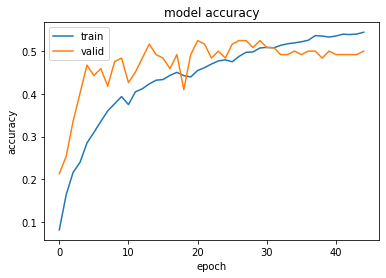

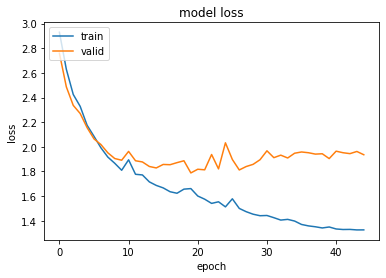

In [46]:
# Training curves
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc = 'upper left')
plt.show()

In [48]:
# References 
# https://colab.research.google.com/drive/1tsiTpC4i26QNdRzBHFfXIOFVToE54-9b?usp=sharing#scrollTo=UHzrWuFpCtzs
# https://github.com/XinhaoLi74
# https://github.com/pharmbio/dl_quantmap